# Model selection and evaluation

__Notes__

1. Create set of rules for what reviews to accept or throw out
    1. Min or max number of words
    1. Include URLs or not
    1. Emojis
    1. Eliminate stop words
    
1. Model selection
    1. CNN for usefulness
    1. Sample from useful reviews only
    1. Setup T5 transfering learning model to generate "justification" text

- LSTM is good
    - You can add in an attention layer because it can look backwards and learn what words were more important than others
- CNN is good for sentence classification 
    - With a fully connected Dense layer it is not good at generalizing
- BERT is good because of its self-attention mechanism where every word looks at every other layer
    - Use the CLS token as the only thing you feed into the output layer that is going to make the prediction on the classification

## 0.0 Notebook setup

### X.X Colab Setup

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)

In [ ]:
! mkdir data

In [ ]:
! cp "/content/gdrive/My Drive/nlp-book-reviews/data/review_samples.csv" ./data/

In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()

In [ ]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

### X.X Local setup

In [1]:
import warnings

warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", FutureWarning)
warnings.simplefilter("ignore", DeprecationWarning)

In [2]:
# Statistics
import numpy as np
import pandas as pd
from scipy.stats import chi2_contingency, norm, skew, kurtosis

# Visualization
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# Model selection and evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report, precision_recall_fscore_support

# Model building
import tensorflow as tf
import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, Bidirectional, Dense, Flatten, LSTM
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

# BERT-specific
from transformers import BertTokenizer, TFBertForSequenceClassification
from transformers import InputExample, InputFeatures

In [3]:
review_samples = pd.read_csv('../data/review_samples.csv')

## X.X Usefulness language modeling

### X.X Bi-directional LSTM

In [59]:
num_words = None
oov_token = '<UNK>'
pad_type = 'post'
trunc_type = 'post'

reviews = review_samples['reviewText']
tokenizer = Tokenizer(num_words=num_words, oov_token=oov_token)
tokenizer.fit_on_texts(reviews)
sequences = tokenizer.texts_to_sequences(reviews)

max_words = len(tokenizer.word_index)
max_len = max([len(x) for x in sequences])
reviews = pad_sequences(sequences, padding=pad_type, truncating=trunc_type, maxlen=max_len)

labels = review_samples['useful']
labels = tf.keras.utils.to_categorical(labels, num_classes=2, dtype="float32")

In [60]:
X_train, X_test, y_train, y_test = train_test_split(reviews,
                                                    labels,
                                                    test_size=0.2,
                                                    random_state=0
                                                   )

In [62]:
# Specify model hyperparameters.
epochs = 5
dropout_rate = 0.7
num_classes = len(np.unique(labels, axis=0))

# Build model
model = Sequential()
model.add(Embedding(max_words, 40, input_length=max_len))
model.add(Bidirectional(LSTM(20, dropout=dropout_rate)))
model.add(Dense(2, activation='softmax'))
model.compile(optimizer='rmsprop',loss='binary_crossentropy', metrics=['accuracy'])

model.fit(X_train, y_train, epochs=epochs)

In [19]:
model.evaluate(X_test, y_test, verbose=1)

34/34 [==============================] - 2s 18ms/step - loss: 0.6873 - accuracy: 0.6026


[0.6873011589050293, 0.6026119589805603]

In [20]:
y_true = y_test.argmax(axis=1)
y_pred = np.argmax(model.predict(X_test), axis=1)

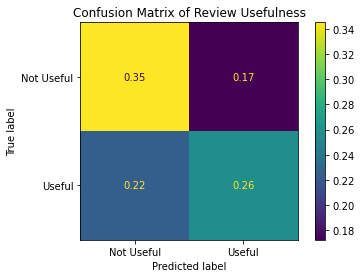

In [21]:
sentiment = ['Not Useful', 'Useful']

ConfusionMatrixDisplay.from_predictions(y_true,
                                        y_pred,
                                        normalize='all',
                                        display_labels=sentiment
                                       )

plt.title("Confusion Matrix of Review Usefulness")
plt.show()

In [24]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.61      0.67      0.63       555
           1       0.60      0.53      0.56       517

    accuracy                           0.60      1072
   macro avg       0.60      0.60      0.60      1072
weighted avg       0.60      0.60      0.60      1072



In [10]:
sequence = tokenizer.texts_to_sequences(['this data science article is the best ever'])
test = pad_sequences(sequence, maxlen=max_len)
sentiment[np.around(model.predict(test), decimals=0).argmax(axis=1)[0]]

'Not Useful'

In [11]:
sequence = tokenizer.texts_to_sequences(['i really loved how the technician helped me with the issue that i had'])
test = pad_sequences(sequence, maxlen=max_len)
sentiment[np.around(model.predict(test), decimals=0).argmax(axis=1)[0]]

'Not Useful'

### X.X BERT

In [ ]:
X, y = review_samples['reviewText'], review_samples['useful']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_train, X_dev, y_train, y_dev = train_test_split(X_train, y_train, test_size=0.25, random_state=0)

train = pd.DataFrame([X_train, y_train]).T
dev = pd.DataFrame([X_dev, y_dev]).T
test = pd.DataFrame([X_test, y_test]).T

In [12]:
def convert_data_to_examples(data, DATA_COLUMN, LABEL_COLUMN): 
    examples = data.apply(lambda x: InputExample(guid=None, # Globally unique ID for bookkeeping, unused in this case
                                                 text_a = x[DATA_COLUMN], 
                                                 text_b = None,
                                                 label = x[LABEL_COLUMN]
                                                ),
                          axis = 1
                         )
  
    return examples


  
def convert_examples_to_tf_dataset(examples, tokenizer, max_length=128):
    features = [] # -> will hold InputFeatures to be converted later

    for e in examples:
        # Documentation is really strong for this method, so please take a look at it
        input_dict = tokenizer.encode_plus(e.text_a,
                                           add_special_tokens=True,
                                           max_length=max_length, # truncates if len(s) > max_length
                                           return_token_type_ids=True,
                                           return_attention_mask=True,
                                           pad_to_max_length=True, # pads to the right by default # CHECK THIS for pad_to_max_length
                                           truncation=True
                                          )

        input_ids = input_dict["input_ids"]
        token_type_ids = input_dict["token_type_ids"] 
        attention_mask = input_dict['attention_mask']

        features.append(InputFeatures(input_ids=input_ids,
                                      attention_mask=attention_mask,
                                      token_type_ids=token_type_ids,
                                      label=e.label
                                     )
                       )

    def gen():
        for f in features:
            yield ({"input_ids": f.input_ids,
                    "attention_mask": f.attention_mask,
                    "token_type_ids": f.token_type_ids,
                   },
                   f.label,
                  )

    return tf.data.Dataset.from_generator(gen,
                                          ({"input_ids": tf.int32,
                                            "attention_mask": tf.int32,
                                            "token_type_ids": tf.int32
                                           },
                                           tf.int64
                                          ),
                                          ({"input_ids": tf.TensorShape([None]),
                                            "attention_mask": tf.TensorShape([None]),
                                            "token_type_ids": tf.TensorShape([None]),
                                           },
                                           tf.TensorShape([]),
                                          ),
                                         )




In [ ]:
DATA_COLUMN = 'reviewText'
LABEL_COLUMN = 'useful'
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

train_InputExamples = convert_data_to_examples(test, DATA_COLUMN, LABEL_COLUMN)
dev_InputExamples = convert_data_to_examples(test, DATA_COLUMN, LABEL_COLUMN)
test_InputExamples = convert_data_to_examples(test, DATA_COLUMN, LABEL_COLUMN)

train_data = convert_examples_to_tf_dataset(list(train_InputExamples), tokenizer)
train_data = train_data.shuffle(100).batch(32).repeat(2)

dev_data = convert_examples_to_tf_dataset(list(dev_InputExamples), tokenizer)
dev_data = dev_data.batch(32)

test_data = convert_examples_to_tf_dataset(list(test_InputExamples), tokenizer)
test_data = test_data.batch(32)

In [ ]:
%%time

# Specify model hyperparameters.
epochs = 5
dropout_rate = 0.7
num_classes = len(np.unique(labels, axis=0))

model = TFBertForSequenceClassification.from_pretrained("bert-base-uncased")

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=3e-5,
                                                 epsilon=1e-08,
                                                 clipnorm=1.0), 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy('accuracy')]
             )

model.fit(train_data, epochs=2, validation_data=dev_data)

In [ ]:
model.summary()

In [ ]:
# test_sentence = "Golf tips magazine is one of the most aptly titled magazines available today. \
#                  It is chock full of heavily-illustrated exercises and other tips for serious golfers to improve their games.\
#                  \nThere are a number of golf magazines on the newstand today. Most of them rely on a lifestyle format relying \
#                  more heavily on lifestyle-type stories about today's hot golfers and the courses they play. Most of them include \
#                  a brief game tip or two but seem aimed at the casual duffer.\nGolf Tips, on the other hand, features almost nothing \
#                  but heavily illustrated tips on improving one's swing, eliminating mistakes and putting better. It also is heavily \
#                  loaded with features on the latest equipment technology. Each issue also seems to feature an article on the technical \
#                  aspects of a selected major golf course. The articles are written with terminology that serious golfers will understand \
#                  but that may confuse the weekend player. Judging by the amount of advertising in its early issues, this magazine also \
#                  appears to be financially healthy.\nIf a reader wants to read about the PGA Tour's superstars, this magazine is not for \
#                  him/her. But if s/he plans to be one of those superstars, Golf Tips is a good match."

test_sentence = "The information is interesting and fun, the writing is superb, and the writers and editors have a great sense of humor. \
                 I just wish it came out more often!"

predict_input = tokenizer.encode(test_sentence,
                                 truncation=True,
                                 padding=True,
                                 return_tensors="tf"
                                 )
tf_output = model.predict(predict_input)[0]
tf_prediction = tf.nn.softmax(tf_output, axis=1)
labels = ['Not Useful','Useful'] #(0:Not Useful, 1:Useful)
label = tf.argmax(tf_prediction, axis=1)
label = label.numpy()
print(labels[label[0]])

### X.X Convolutional neural network

In [26]:
import re

def clean_str(string):
    """
    Tokenization/string cleaning
    """
    string = re.sub(r"[^A-Za-z0-9(),!?\'\`]", " ", string)
    string = re.sub(r"\'s", " \'s", string)
    string = re.sub(r"\'ve", " \'ve", string)
    string = re.sub(r"n\'t", " n\'t", string)
    string = re.sub(r"\'re", " \'re", string)
    string = re.sub(r"\'d", " \'d", string)
    string = re.sub(r"\'ll", " \'ll", string)
    string = re.sub(r",", " , ", string)
    string = re.sub(r"!", " ! ", string)
    string = re.sub(r"\(", " \( ", string)
    string = re.sub(r"\)", " \) ", string)
    string = re.sub(r"\?", " \? ", string)
    string = re.sub(r"\s{2,}", " ", string)
    return string.strip().lower()

In [30]:
review_samples['reviewProcessed'] = review_samples['reviewText'].apply(lambda row: clean_str(row))

# Example review
print(review_samples["reviewText"].iloc[1])
print("")
print(review_samples["reviewProcessed"].iloc[1])
print("")

Confirming as of April 2010 - The magazines do NOT come packaged with the software CD's as pictured on the product page, nor does the description disclaim that this is some kind no-CD subscription of the magazine.

The reviews on the ridiculous time frames in which you receive your first issue are, unfortunately, true as well. The description claims 6-10 weeks, but it could take several months longer.

Falsely advertised; buy directly through Maximum PC or a more reliable source where you'll actually get all 12 months with all 12 software discs, rather than 6-10 issues with no discs.

This product is NOT the product described. It's as simple as that.

confirming as of april 2010 the magazines do not come packaged with the software cd 's as pictured on the product page , nor does the description disclaim that this is some kind no cd subscription of the magazine the reviews on the ridiculous time frames in which you receive your first issue are , unfortunately , true as well the descript

In [115]:
num_words = None
oov_token = '<UNK>'
pad_type = 'post'
trunc_type = 'post'

reviews = review_samples['reviewText']
tokenizer = Tokenizer(num_words=top_words, oov_token=oov_token)
tokenizer.fit_on_texts(reviews)
sequences = tokenizer.texts_to_sequences(reviews)

# top_words = len(tokenizer.word_index)
# max_words = max([len(x) for x in sequences])
top_words = 7000
max_words = 450

reviews = pad_sequences(sequences, padding=pad_type, truncating=trunc_type, maxlen=max_words)

review_samples['useful'] = review_samples['useful'].astype(int)
labels = review_samples['useful']
# labels = tf.keras.utils.to_categorical(labels, num_classes=2, dtype="float32")

In [117]:
X_train, X_test, y_train, y_test = train_test_split(reviews,
                                                    labels,
                                                    test_size=0.2,
                                                    random_state=0
                                                   )

In [103]:
# Specify model hyperparameters
epochs = 5
batch_size = 128
num_filters = [2, 2, 2]
kernel_sizes = [2, 3, 4]
dense_layer_dims = [10, 4]
dropout_rate = 0.7
num_classes = len(np.unique(labels, axis=0))


# Build Model
model = Sequential()
model.add(Embedding(top_words, 32, input_length=max_words))
model.add(Conv1D(32, 3, padding='same', activation='relu'))
model.add(MaxPooling1D())
model.add(Flatten())
model.add(Dense(250, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

model.fit(X_train,
          y_train,
          validation_data=(X_test, y_test),
          epochs=epochs,
          batch_size=batch_size,
          verbose=2)

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 450, 32)           224000    
                                                                 
 conv1d_5 (Conv1D)           (None, 450, 32)           3104      
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 225, 32)          0         
 1D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 7200)              0         
                                                                 
 dense_9 (Dense)             (None, 250)               1800250   
                                                                 
 dense_10 (Dense)            (None, 1)                 251       
                                                      

In [119]:
# Fitting the data onto model
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=128, verbose=2)
# Getting score metrics from our model
scores = model.evaluate(X_test, y_test, verbose=0)
# Displays the accuracy of correct sentiment prediction over test data
print("Accuracy: %.2f%%" % (scores[1]*100))

Epoch 1/10
34/34 - 4s - loss: 0.5639 - accuracy: 0.7435 - val_loss: 0.6889 - val_accuracy: 0.5681 - 4s/epoch - 118ms/step
Epoch 2/10
34/34 - 4s - loss: 0.3066 - accuracy: 0.9062 - val_loss: 0.8302 - val_accuracy: 0.5746 - 4s/epoch - 106ms/step
Epoch 3/10
34/34 - 4s - loss: 0.1089 - accuracy: 0.9764 - val_loss: 0.9741 - val_accuracy: 0.5597 - 4s/epoch - 111ms/step
Epoch 4/10
34/34 - 4s - loss: 0.0446 - accuracy: 0.9937 - val_loss: 1.1107 - val_accuracy: 0.5644 - 4s/epoch - 115ms/step
Epoch 5/10
34/34 - 4s - loss: 0.0248 - accuracy: 0.9986 - val_loss: 1.2140 - val_accuracy: 0.5812 - 4s/epoch - 126ms/step
Epoch 6/10
34/34 - 4s - loss: 0.0129 - accuracy: 0.9991 - val_loss: 1.3502 - val_accuracy: 0.5522 - 4s/epoch - 122ms/step
Epoch 7/10
34/34 - 4s - loss: 0.0110 - accuracy: 0.9991 - val_loss: 1.3260 - val_accuracy: 0.5494 - 4s/epoch - 109ms/step
Epoch 8/10
34/34 - 4s - loss: 0.0123 - accuracy: 0.9986 - val_loss: 1.3772 - val_accuracy: 0.5392 - 4s/epoch - 117ms/step
Epoch 9/10
34/34 - 4s - 

### CNN setup from assignment 4

In [64]:
# Specify model hyperparameters
epochs = 5
embed_dim = 5
num_filters = [2, 2, 2]
kernel_sizes = [2, 3, 4]
dense_layer_dims = [10, 4]
dropout_rate = 0.7
num_classes = len(np.unique(labels, axis=0))

# Construct the convolutional neural network.
# The form of each keras layer function is as follows:
#    result = keras.layers.LayerType(arguments for the layer)(layer(s) it should use as input)
# concretely,
#    this_layer_output = keras.layers.Dense(100, activation='relu')(prev_layer_vector)
# performs this_layer_output = relu(prev_layer_vector x W + b) where W has 100 columns.

# Input is a special "layer".  It defines a placeholder that will be overwritten by the training data.
# In our case, we are accepting a list of wordids (padded out to max_len).
wordids = keras.layers.Input(shape=(max_len,))

# Embed the wordids.
# Recall, this is just a mathematically equivalent operation to a linear layer and a one-hot
h = keras.layers.Embedding(max_words, embed_dim, input_length=max_len)(wordids)

# Construct "filters" randomly initialized filters with dimension "kernel_size" for each size of filter we want.
# With the default hyperparameters, we construct 2 filters each of size 2, 3, 4.  As in the image above, each filter
# is wide enough to span the whole word embedding (this is why the convolution is "1d" as seen in the
# function name below).
conv_layers_for_all_kernel_sizes = []
for kernel_size, filters in zip(kernel_sizes, num_filters):
    conv_layer = Conv1D(filters=filters, kernel_size=kernel_size, activation='relu')(h)
    conv_layer = GlobalMaxPooling1D()(conv_layer)
    conv_layers_for_all_kernel_sizes.append(conv_layer)

# Concat the feature maps from each different size.
h = keras.layers.concatenate(conv_layers_for_all_kernel_sizes, axis=1)

# Dropout can help with overfitting (improve generalization) by randomly 0-ing different subsets of values
# in the vector.
# See https://www.cs.toronto.edu/~hinton/absps/JMLRdropout.pdf for details.
h = keras.layers.Dropout(rate=dropout_rate)(h)

prediction = keras.layers.Dense(num_classes, activation='softmax')(h)

model = keras.Model(inputs=wordids, outputs=prediction)
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',  # From information theory notebooks.
              metrics=['accuracy'])        # What metric to output as we train.

In [120]:
model.fit(X_train, y_train, epochs=epochs)

## X.X Explanation transfer learning

In [128]:
# from transformers.models.t5 import T5Model
from transformers import TFT5Model

In [133]:
model_args = {
    "reprocess_input_data": True,
    "overwrite_output_dir": True,
    "max_seq_length": 128,
    "train_batch_size": 8,
    "num_train_epochs": 1,
    "save_eval_checkpoints": True,
    "save_steps": -1,
    "use_multiprocessing": False,
    "evaluate_during_training": True,
    "evaluate_during_training_steps": 15000,
    "evaluate_during_training_verbose": True,
    "fp16": False,

    "wandb_project": "Question Generation with T5",
}

model = TFT5Model.from_pretrained("t5-small")

https://huggingface.co/t5-small/resolve/main/config.json not found in cache or force_download set to True, downloading to /Users/dmiller/.cache/huggingface/transformers/tmp_nunrfgi


Downloading:   0%|          | 0.00/1.17k [00:00<?, ?B/s]

storing https://huggingface.co/t5-small/resolve/main/config.json in cache at /Users/dmiller/.cache/huggingface/transformers/fe501e8fd6425b8ec93df37767fcce78ce626e34cc5edc859c662350cf712e41.406701565c0afd9899544c1cb8b93185a76f00b31e5ce7f6e18bbaef02241985
creating metadata file for /Users/dmiller/.cache/huggingface/transformers/fe501e8fd6425b8ec93df37767fcce78ce626e34cc5edc859c662350cf712e41.406701565c0afd9899544c1cb8b93185a76f00b31e5ce7f6e18bbaef02241985
loading configuration file https://huggingface.co/t5-small/resolve/main/config.json from cache at /Users/dmiller/.cache/huggingface/transformers/fe501e8fd6425b8ec93df37767fcce78ce626e34cc5edc859c662350cf712e41.406701565c0afd9899544c1cb8b93185a76f00b31e5ce7f6e18bbaef02241985
Model config T5Config {
  "architectures": [
    "T5WithLMHeadModel"
  ],
  "d_ff": 2048,
  "d_kv": 64,
  "d_model": 512,
  "decoder_start_token_id": 0,
  "dropout_rate": 0.1,
  "eos_token_id": 1,
  "feed_forward_proj": "relu",
  "initializer_factor": 1.0,
  "is_enco

Downloading:   0%|          | 0.00/231M [00:00<?, ?B/s]

storing https://huggingface.co/t5-small/resolve/main/tf_model.h5 in cache at /Users/dmiller/.cache/huggingface/transformers/51663d3eebce1656ebbf9cb26c16e243c19f861394299c088496b86b32ef4831.a6c374775a2dd6a6843e2ada3202ba6acae7cf400a3b1bfdca2ec2341e669716.h5
creating metadata file for /Users/dmiller/.cache/huggingface/transformers/51663d3eebce1656ebbf9cb26c16e243c19f861394299c088496b86b32ef4831.a6c374775a2dd6a6843e2ada3202ba6acae7cf400a3b1bfdca2ec2341e669716.h5
loading weights file https://huggingface.co/t5-small/resolve/main/tf_model.h5 from cache at /Users/dmiller/.cache/huggingface/transformers/51663d3eebce1656ebbf9cb26c16e243c19f861394299c088496b86b32ef4831.a6c374775a2dd6a6843e2ada3202ba6acae7cf400a3b1bfdca2ec2341e669716.h5
2022-03-19 16:05:33.679479: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
All model checkpoint layers were used when initializing TFT5Model.

All the layers of

### X.X Pre-trained sentiment span extraction model

https://huggingface.co/mrm8488/t5-base-finetuned-span-sentiment-extraction

In [10]:
example = review_samples.iloc[2]['reviewText']

In [4]:
from transformers import AutoModelWithLMHead, AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("mrm8488/t5-base-finetuned-span-sentiment-extraction")
model = AutoModelWithLMHead.from_pretrained("mrm8488/t5-base-finetuned-span-sentiment-extraction")

def get_sentiment_span(text):
    input_ids = tokenizer.encode(text, return_tensors="pt", add_special_tokens=True)  # Batch size 1

    generated_ids = model.generate(input_ids=input_ids, num_beams=1, max_length=80).squeeze()

    predicted_span = tokenizer.decode(generated_ids, skip_special_tokens=True, clean_up_tokenization_spaces=True)

    return predicted_span
  
get_sentiment_span("question: negative context: My bike was put on hold...should have known that.... argh total bummer")

# output: 'argh total bummer'

get_sentiment_span("question: positive context: On the monday, so i wont be able to be with you! i love you")

# output: 'i love you'

Downloading:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/773k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/65.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/850M [00:00<?, ?B/s]

'i love you!'

In [14]:
get_sentiment_span("question: negative context: {}".format(example))

'biggest kick in the rear end, is that I could only get 10 of the CDs now, because I had the first issue and the second issue was too close to shipping.'

In [12]:
review_samples.iloc[2]['reviewText']

"Please understand that I have been a subscriber to Maximum PC Magazine for YEARS. I think it is probably one of the most entertaining Tech Magazines available, and the Disks that come with this little gem are absolutely packed full of the best freeware/shareware available anywhere! So imagine my excitement when I saw this offer. 12 issues of Maximum PC with what I assumed had to be the CDs because of the cover price listed and the savings. That was incredible. NO it wasn't. I ordered this and found out that this is the PRINT ONLY edition. NO CD's. Upon calling Maximum PC they said it would be another [...] per month for the CDs but the biggest kick in the rear end, is that I could only get 10 of the CDs now, because I had the first issue and the second issue was too close to shipping. IF I JUST WANTED THE MAGAZINE I COULD HAVE JUST DOWNLOADED THE FREE PDF'S THAT MAXIMUM PC MAKES AVAILABLE ON THERE WEBSITE. I WANTED BOTH. BTW AMAZON CUSTOMER SERVICE REFUSES TO DO ANYTHING ABOUT THIS OT